In [1]:
# Импорт необходимых библиотек
import numpy as np
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2023-10-09 12:10:43.472250: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 12:10:43.713251: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-09 12:10:43.714685: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-09 12:10:44.384211: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
if tf.config.list_physical_devices('GPU'):
    print(tf.config.list_physical_devices('GPU'))
else:
    print("TensorFlow GPU not found!")

TensorFlow GPU not found!


2023-10-09 12:10:49.533284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-09 12:10:49.677227: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
%%time
with tf.device('/GPU:0'):
    a = tf.constant([1.0, 2.0, 3.0], shape=[3], name='a')
    b = tf.constant([1.0, 2.0, 3.0], shape=[3], name='b')
    c = tf.add(a, b)

print(c)

tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32)
CPU times: user 12.5 ms, sys: 4.24 ms, total: 16.7 ms
Wall time: 21 ms


In [4]:
%%time
with tf.device('/CPU:0'):
    a = tf.constant([1.0, 2.0, 3.0], shape=[3], name='a')
    b = tf.constant([1.0, 2.0, 3.0], shape=[3], name='b')
    c = tf.add(a, b)

print(c)

tf.Tensor([2. 4. 6.], shape=(3,), dtype=float32)
CPU times: user 708 µs, sys: 0 ns, total: 708 µs
Wall time: 608 µs


In [5]:
# Загрузка CIFAR-10 датасета
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

In [6]:
# Нормализация изображений
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Преобразование меток в one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [11]:
train_images.shape, test_images.shape,

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [7]:
# Создание объекта ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [8]:
# Выполнение аугментации данных с использованием datagen
datagen.fit(train_images)

# Пример использования .flow() для обучения модели
# model.fit(datagen.flow(train_images, train_labels, batch_size=32), steps_per_epoch=len(train_images) / 32, epochs=10)

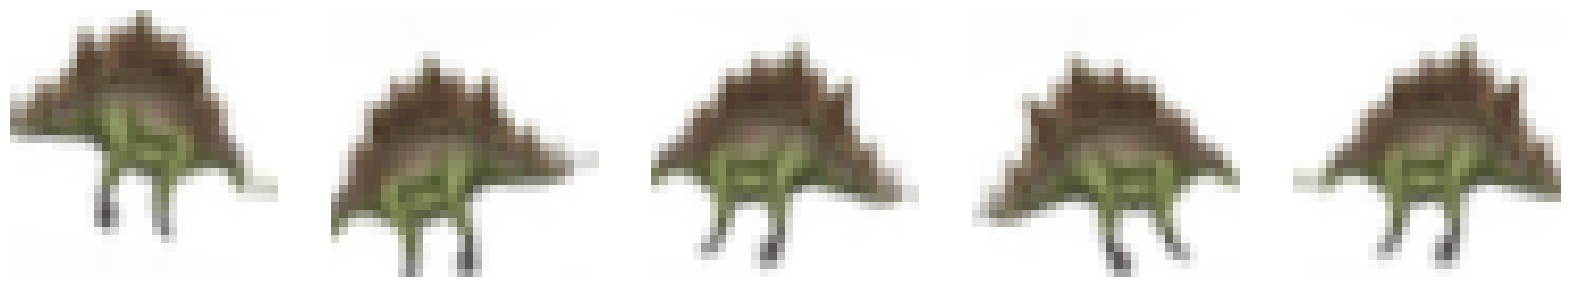

In [9]:
# Генерация аугментированных изображений
augmented_images = [train_images[1] for i in range(5)]
augmented_images = np.array(augmented_images)
augmented_images = datagen.flow(augmented_images, batch_size=5, shuffle=False).next()

# Визуализация изображений
fig, axarr = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    axarr[i].imshow(augmented_images[i])
    axarr[i].axis('off')

plt.show()


In [15]:
test_images.shape

(10000, 32, 32, 3)

In [37]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), padding = "same", activation='relu', strides = 1, input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    # MaxPooling2D((2, 2)), # Слой пулинга
    # Dropout(0.1),
    
    # Conv2D(512, (2, 2), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    # MaxPooling2D((2, 2)), # Слой пулинга
    
    # Conv2D(512, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    # MaxPooling2D((3, 3)), # Слой пулинга
    # # Conv2D(256, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    # Flatten(), # Преобразование матрицы признаков в вектор
    # Dense(256, activation='relu'), # Полносвязный слой
    
    MaxPooling2D((2, 2), strides=2),
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(512, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),#, strides=2),
    Dropout(0.25), 
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    
    
    Dense(100, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 8, 8, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 4, 4, 64)         

In [38]:

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=128),
          steps_per_epoch=200,#len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels))


Epoch 1/10
200/200 [==============================] - 14s 66ms/step - loss: 4.5121 - accuracy: 0.0183 - val_loss: 4.3580 - val_accuracy: 0.0337
Epoch 2/10
200/200 [==============================] - 13s 66ms/step - loss: 4.2247 - accuracy: 0.0409 - val_loss: 4.0241 - val_accuracy: 0.0601
Epoch 3/10
200/200 [==============================] - 13s 65ms/step - loss: 3.9544 - accuracy: 0.0716 - val_loss: 3.8149 - val_accuracy: 0.0907
Epoch 4/10
200/200 [==============================] - 13s 64ms/step - loss: 3.8075 - accuracy: 0.0925 - val_loss: 3.6923 - val_accuracy: 0.1225
Epoch 5/10
200/200 [==============================] - 13s 65ms/step - loss: 3.6624 - accuracy: 0.1216 - val_loss: 3.6496 - val_accuracy: 0.1237
Epoch 6/10
200/200 [==============================] - 13s 66ms/step - loss: 3.5626 - accuracy: 0.1398 - val_loss: 3.4804 - val_accuracy: 0.1589
Epoch 7/10
200/200 [==============================] - 13s 66ms/step - loss: 3.4581 - accuracy: 0.1564 - val_loss: 3.4656 - val_accuracy:

In [28]:
# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=400,#len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels))

Epoch 1/10
400/400 [==============================] - 4s 10ms/step - loss: 2.6821 - accuracy: 0.3173 - val_loss: 2.6692 - val_accuracy: 0.3235
Epoch 2/10
400/400 [==============================] - 4s 10ms/step - loss: 2.6675 - accuracy: 0.3235 - val_loss: 2.6047 - val_accuracy: 0.3341
Epoch 3/10
400/400 [==============================] - 4s 10ms/step - loss: 2.6758 - accuracy: 0.3165 - val_loss: 2.6510 - val_accuracy: 0.3277
Epoch 4/10
400/400 [==============================] - 4s 10ms/step - loss: 2.6707 - accuracy: 0.3123 - val_loss: 2.7900 - val_accuracy: 0.3028
Epoch 5/10
400/400 [==============================] - 4s 10ms/step - loss: 2.6264 - accuracy: 0.3292 - val_loss: 2.6455 - val_accuracy: 0.3308
Epoch 6/10
400/400 [==============================] - 4s 10ms/step - loss: 2.6415 - accuracy: 0.3263 - val_loss: 2.6702 - val_accuracy: 0.3254
Epoch 7/10
400/400 [==============================] - 4s 10ms/step - loss: 2.6174 - accuracy: 0.3287 - val_loss: 2.6562 - val_accuracy: 0.3271

In [39]:
# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          #steps_per_epoch=400,#len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 27s 17ms/step - loss: 3.2531 - accuracy: 0.2021 - val_loss: 3.0819 - val_accuracy: 0.2412
Epoch 2/10
1563/1563 [==============================] - 27s 17ms/step - loss: 3.0595 - accuracy: 0.2360 - val_loss: 2.8680 - val_accuracy: 0.2774
Epoch 3/10
1563/1563 [==============================] - 27s 17ms/step - loss: 2.9481 - accuracy: 0.2627 - val_loss: 2.8191 - val_accuracy: 0.2900
Epoch 4/10
1563/1563 [==============================] - 27s 17ms/step - loss: 2.8452 - accuracy: 0.2819 - val_loss: 2.8427 - val_accuracy: 0.2833
Epoch 5/10
1563/1563 [==============================] - 27s 17ms/step - loss: 2.7786 - accuracy: 0.2965 - val_loss: 2.7375 - val_accuracy: 0.3124
Epoch 6/10
1563/1563 [==============================] - 27s 17ms/step - loss: 2.7162 - accuracy: 0.3105 - val_loss: 2.6381 - val_accuracy: 0.3249
Epoch 7/10
1563/1563 [==============================] - 27s 17ms/step - loss: 2.6635 - accuracy: 0.3199 - val_loss: 2.6333 -

1/1 [==============================] - 0s 72ms/step


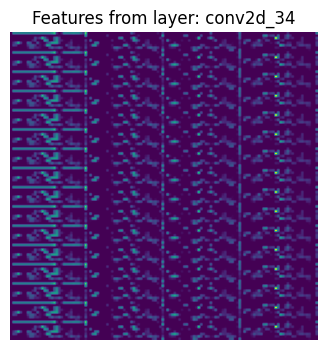

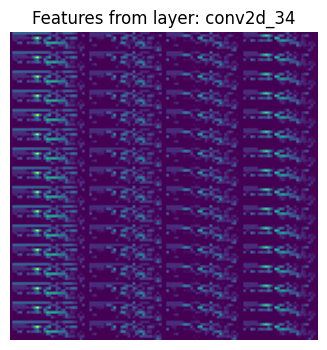

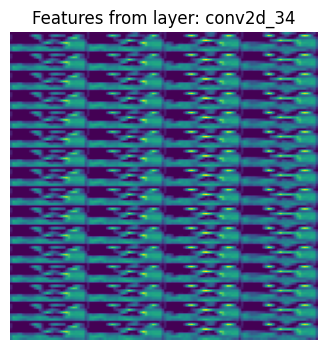

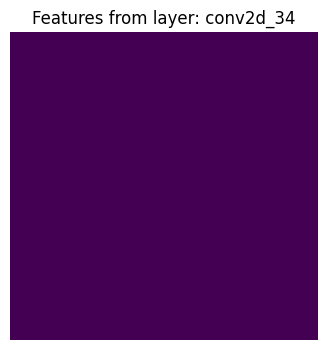

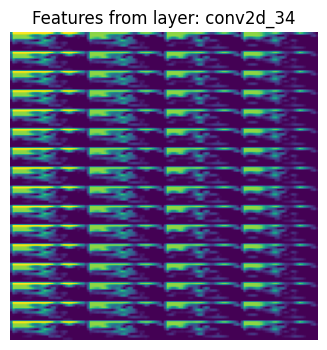

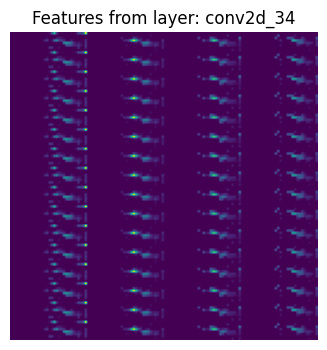

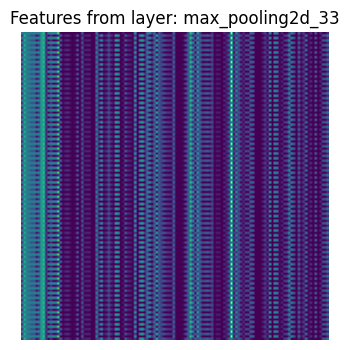

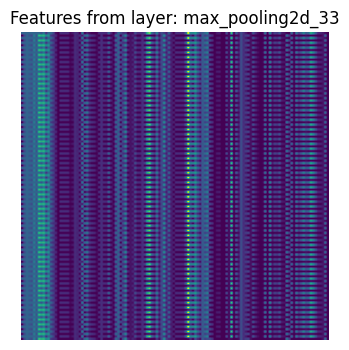

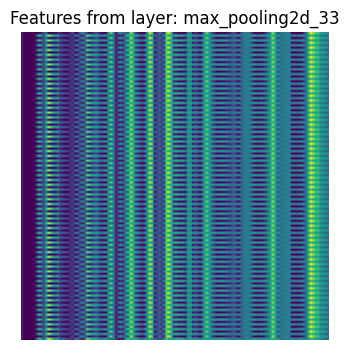

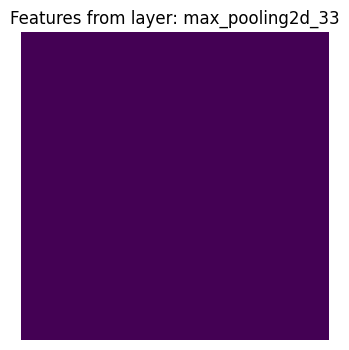

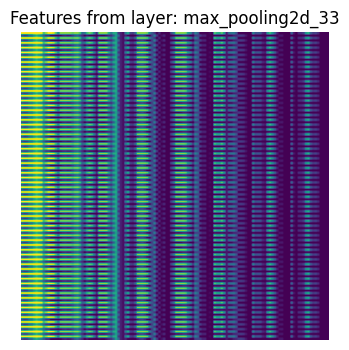

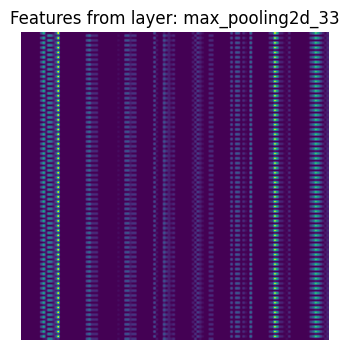

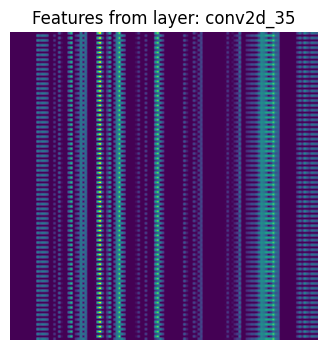

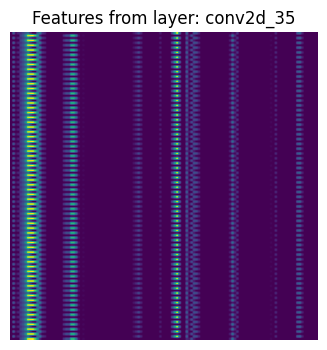

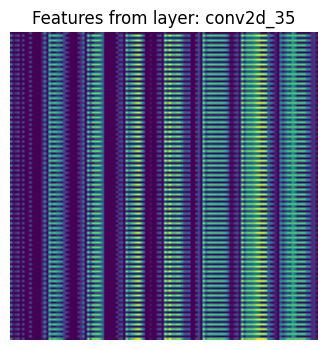

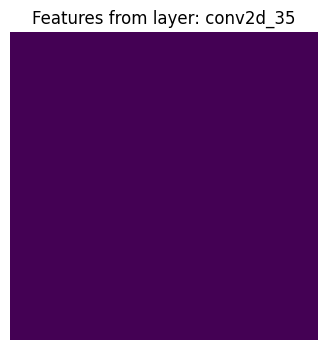

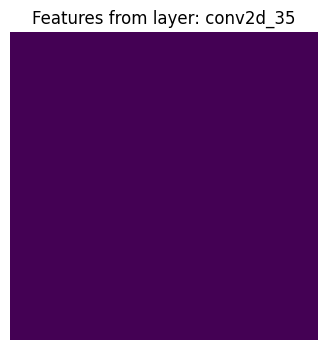

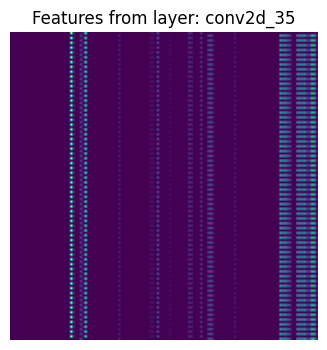

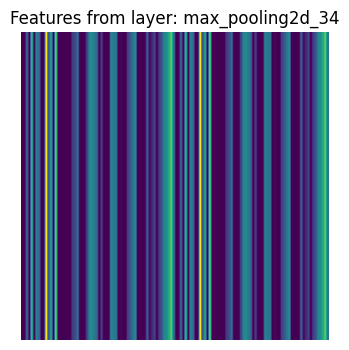

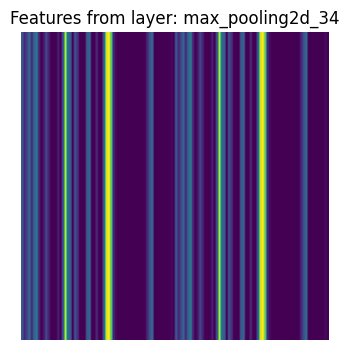

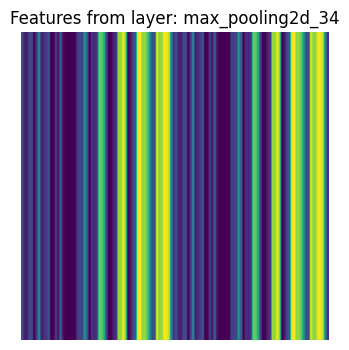

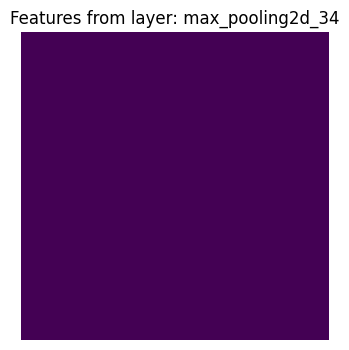

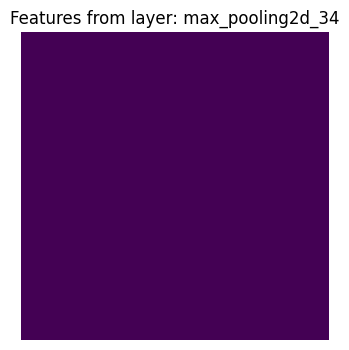

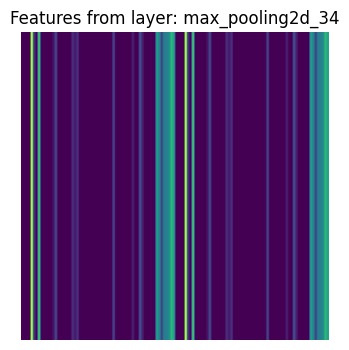

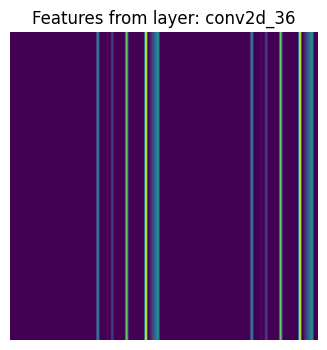

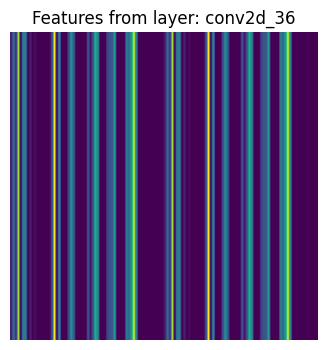

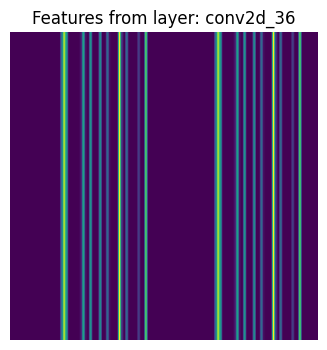

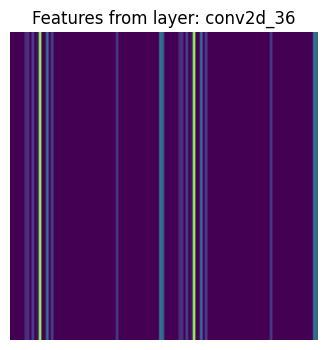

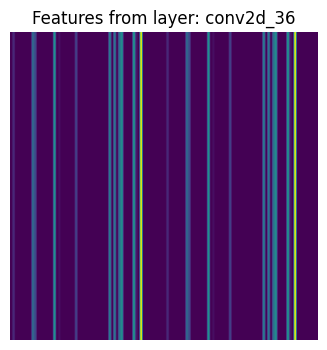

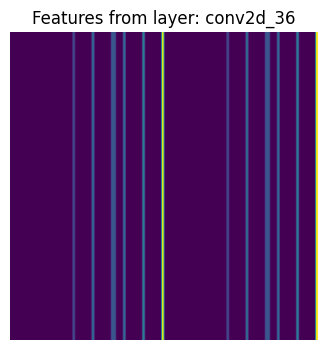

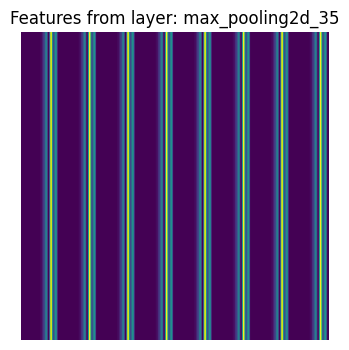

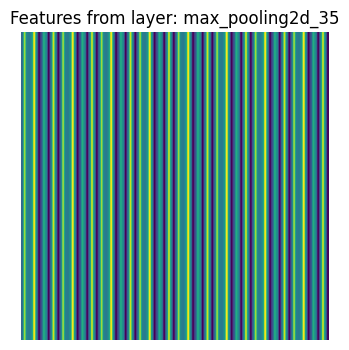

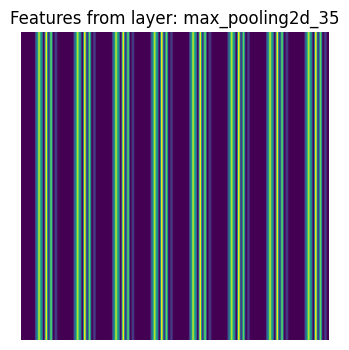

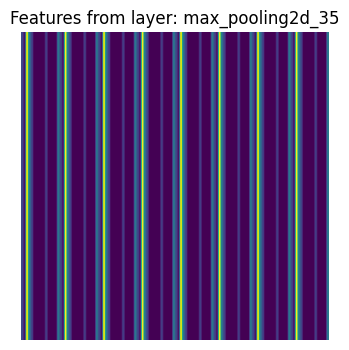

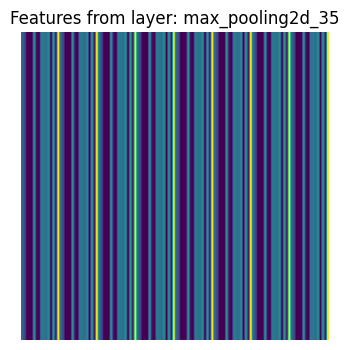

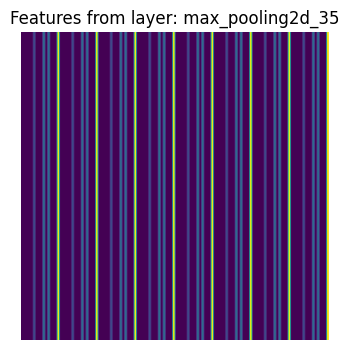

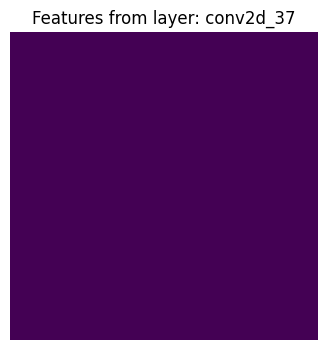

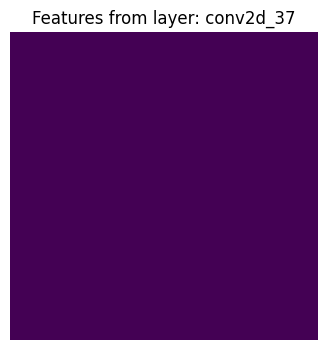

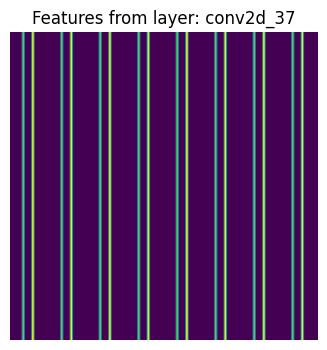

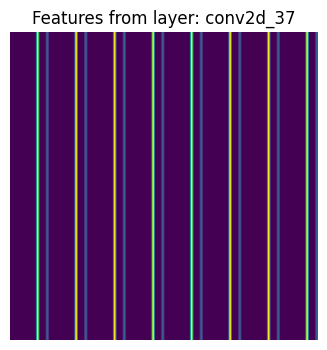

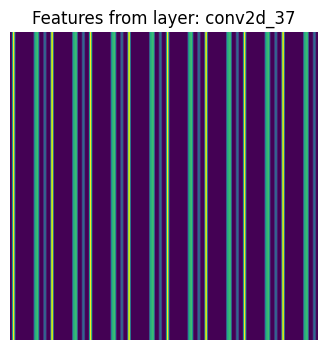

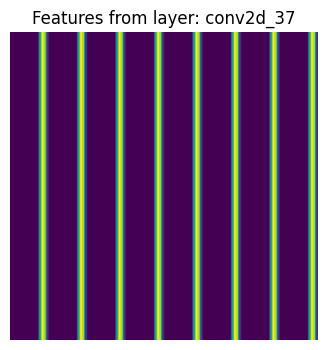

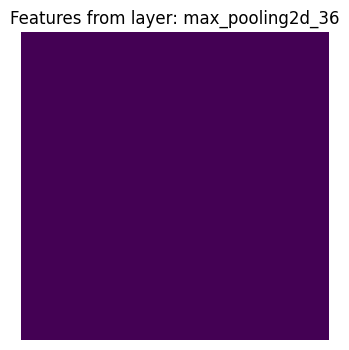

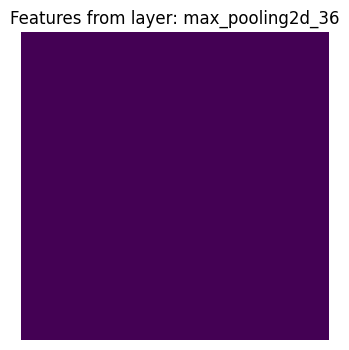

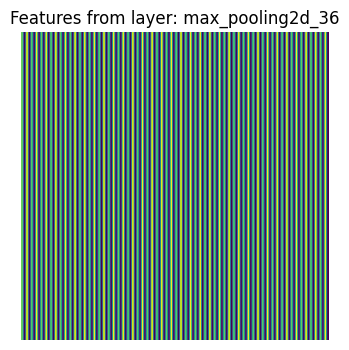

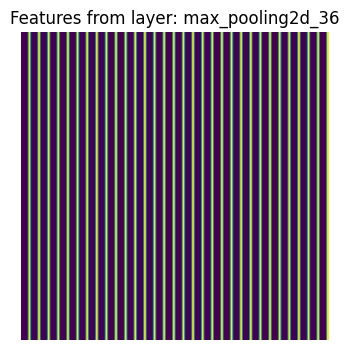

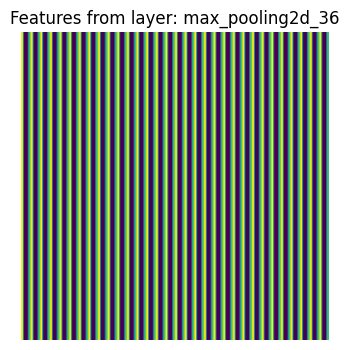

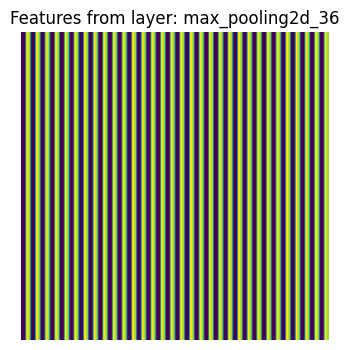

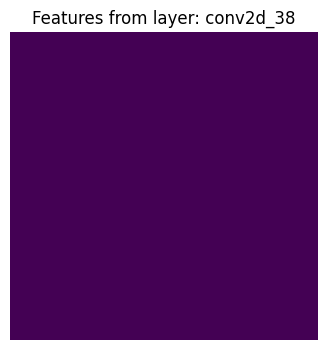

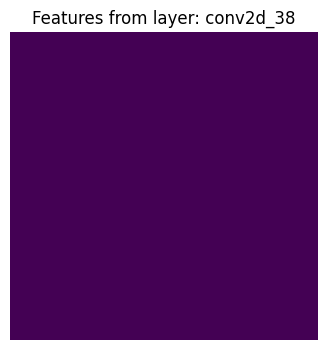

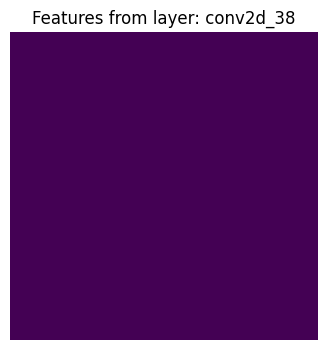

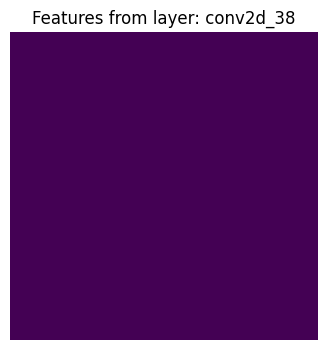

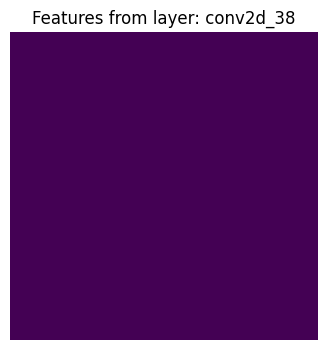

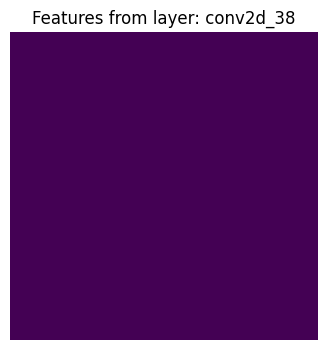

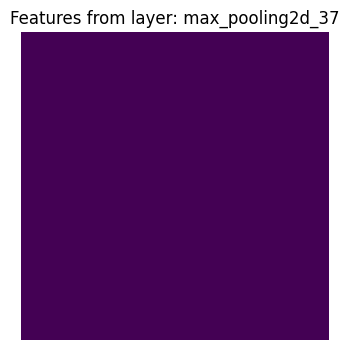

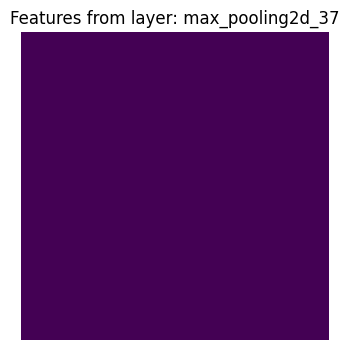

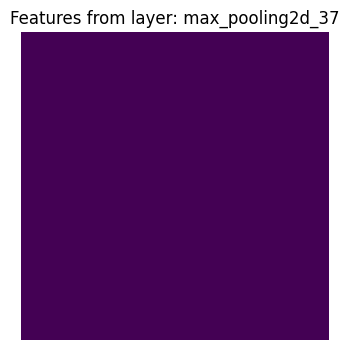

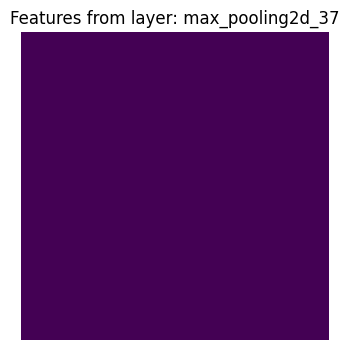

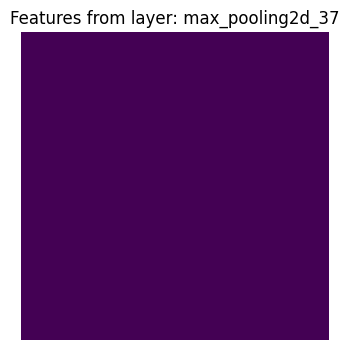

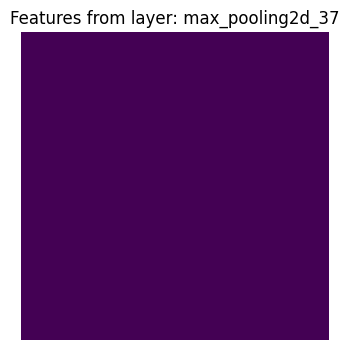

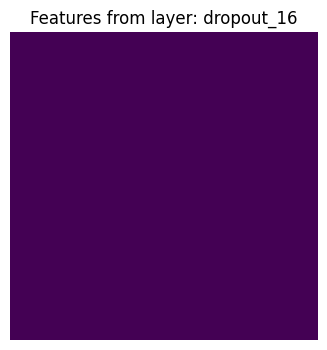

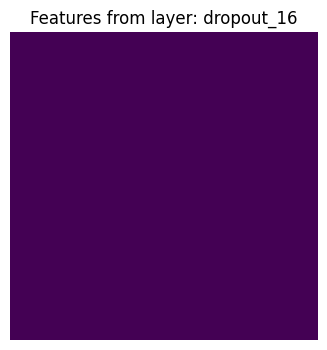

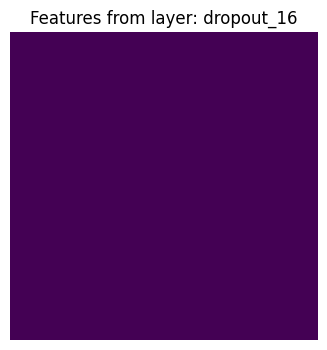

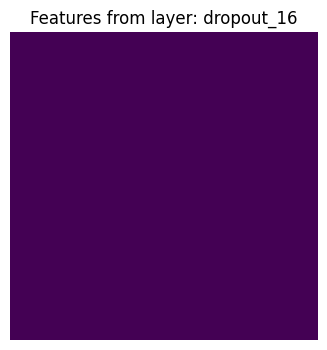

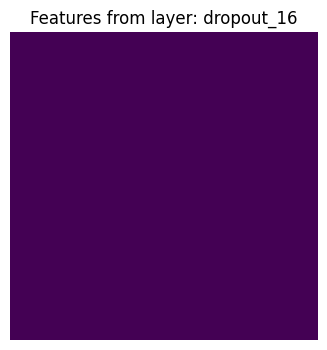

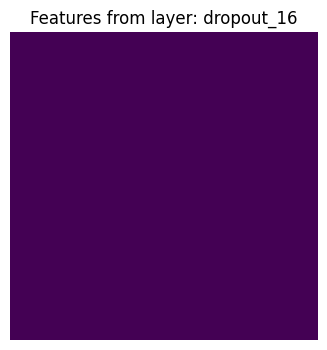

In [40]:
# Выберем одно изображение для визуализации признаков
img = train_images[0]
img = np.expand_dims(img, axis=0)  # расширим измерения для соответствия входному формату модели

# Получим выходные данные каждого слоя для выбранного изображения
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img)

# Функция для интерполяции изображений до размера 128x128
def upscale_to_128x128(img):
    return np.resize(img, (128, 128))

# Визуализация признаков
for layer_name, layer_activation in zip([layer.name for layer in model.layers], activations):
    # Если активация имеет 4 измерения (как в случае с Conv2D и MaxPooling2D)
    if len(layer_activation.shape) == 4:
        # Выберем первые 6 признаковых карт для визуализации
        for i in range(6):
            plt.figure(figsize=(16, 4))
            
            # Некоторые слои могут иметь менее 6 каналов, в таком случае мы визуализируем только имеющиеся
            if layer_activation.shape[-1] >= i+1:
                channel_image = layer_activation[0, :, :, i]
                channel_image = upscale_to_128x128(channel_image)  # Интерполяция до размера 128x128
                plt.imshow(channel_image, cmap='viridis')
                plt.title(f"Features from layer: {layer_name}")
                plt.axis('off')
        plt.show()


In [41]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(100, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Определение каллбека
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping])

Epoch 1/10
1562/1562 [==============================] - 21s 13ms/step - loss: 3.9791 - accuracy: 0.0853 - val_loss: 3.5813 - val_accuracy: 0.1453
Epoch 2/10
1562/1562 [==============================] - 20s 13ms/step - loss: 3.4545 - accuracy: 0.1691 - val_loss: 3.2600 - val_accuracy: 0.2076
Epoch 3/10
1562/1562 [==============================] - 20s 13ms/step - loss: 3.2075 - accuracy: 0.2160 - val_loss: 3.0317 - val_accuracy: 0.2548
Epoch 4/10
1562/1562 [==============================] - 20s 13ms/step - loss: 3.0467 - accuracy: 0.2463 - val_loss: 2.9435 - val_accuracy: 0.2628
Epoch 5/10
1562/1562 [==============================] - 21s 13ms/step - loss: 2.9334 - accuracy: 0.2678 - val_loss: 2.8083 - val_accuracy: 0.2938
Epoch 6/10
1562/1562 [==============================] - 20s 13ms/step - loss: 2.8393 - accuracy: 0.2870 - val_loss: 2.7439 - val_accuracy: 0.3106
Epoch 7/10
1562/1562 [==============================] - 20s 13ms/step - loss: 2.7690 - accuracy: 0.3040 - val_loss: 2.7111 -

In [43]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(100, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Определение каллбеков
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping, reduce_lr])


Epoch 1/10
1562/1562 [==============================] - 21s 13ms/step - loss: 4.0430 - accuracy: 0.0768 - val_loss: 3.6463 - val_accuracy: 0.1408 - lr: 0.0010
Epoch 2/10
1562/1562 [==============================] - 20s 13ms/step - loss: 3.4718 - accuracy: 0.1663 - val_loss: 3.2936 - val_accuracy: 0.2046 - lr: 0.0010
Epoch 3/10
1562/1562 [==============================] - 20s 13ms/step - loss: 3.2188 - accuracy: 0.2135 - val_loss: 3.1056 - val_accuracy: 0.2394 - lr: 0.0010
Epoch 4/10
1562/1562 [==============================] - 21s 13ms/step - loss: 3.0673 - accuracy: 0.2431 - val_loss: 2.9893 - val_accuracy: 0.2568 - lr: 0.0010
Epoch 5/10
1562/1562 [==============================] - 21s 13ms/step - loss: 2.9665 - accuracy: 0.2624 - val_loss: 2.8949 - val_accuracy: 0.2755 - lr: 0.0010
Epoch 6/10
1562/1562 [==============================] - 21s 13ms/step - loss: 2.8841 - accuracy: 0.2779 - val_loss: 2.8167 - val_accuracy: 0.2946 - lr: 0.0010
Epoch 7/10
1562/1562 [========================

In [45]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
import datetime

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(100, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Определение каллбеков
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

# Добавление TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=50,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping, reduce_lr, tensorboard_callback])

Epoch 1/50
1562/1562 [==============================] - 22s 14ms/step - loss: 4.0451 - accuracy: 0.0744 - val_loss: 3.6629 - val_accuracy: 0.1367 - lr: 0.0010
Epoch 2/50
1562/1562 [==============================] - 21s 13ms/step - loss: 3.5005 - accuracy: 0.1627 - val_loss: 3.3091 - val_accuracy: 0.1997 - lr: 0.0010
Epoch 3/50
1562/1562 [==============================] - 21s 13ms/step - loss: 3.2410 - accuracy: 0.2080 - val_loss: 3.1603 - val_accuracy: 0.2338 - lr: 0.0010
Epoch 4/50
1562/1562 [==============================] - 21s 13ms/step - loss: 3.0829 - accuracy: 0.2379 - val_loss: 3.1595 - val_accuracy: 0.2316 - lr: 0.0010
Epoch 5/50
1562/1562 [==============================] - 21s 13ms/step - loss: 2.9751 - accuracy: 0.2604 - val_loss: 2.8892 - val_accuracy: 0.2818 - lr: 0.0010
Epoch 6/50
1562/1562 [==============================] - 21s 13ms/step - loss: 2.8935 - accuracy: 0.2748 - val_loss: 2.8181 - val_accuracy: 0.2946 - lr: 0.0010
Epoch 7/50
1562/1562 [========================

In [46]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11296), started 0:14:23 ago. (Use '!kill 11296' to kill it.)

In [48]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import datetime

# Определение структуры модели
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # Сверточный слой с 32 фильтрами
    MaxPooling2D((3, 3)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Следующий сверточный слой с 64 фильтрами
    MaxPooling2D((2, 2)), # Слой пулинга
    Conv2D(64, (3, 3), activation='relu'), # Еще один сверточный слой с 64 фильтрами
    Flatten(), # Преобразование матрицы признаков в вектор
    Dense(64, activation='relu'), # Полносвязный слой
    Dense(100, activation='softmax') # Выходной слой с 10 нейронами (по количеству классов в CIFAR-10)
])

# Компиляция модели
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Определение каллбеков
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

# Добавление TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Добавление ModelCheckpoint callback
best_model_path = "best_model.h5"
checkpoint_callback = ModelCheckpoint(best_model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Обучение модели
model.fit(datagen.flow(train_images, train_labels, batch_size=32),
          steps_per_epoch=len(train_images) / 32,
          epochs=10,
          validation_data=(test_images, test_labels),
          callbacks=[early_stopping, reduce_lr, tensorboard_callback,checkpoint_callback])

Epoch 1/10
1561/1562 [============================>.] - ETA: 0s - loss: 4.0613 - accuracy: 0.0718
Epoch 1: val_accuracy improved from -inf to 0.13220, saving model to best_model.h5
1562/1562 [==============================] - 18s 12ms/step - loss: 4.0604 - accuracy: 0.0720 - val_loss: 3.6489 - val_accuracy: 0.1322 - lr: 0.0010
Epoch 2/10
  11/1562 [..............................] - ETA: 17s - loss: 3.5917 - accuracy: 0.1364

/home/esrv/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1563/1562 [==============================] - ETA: 0s - loss: 3.5384 - accuracy: 0.1516
Epoch 2: val_accuracy improved from 0.13220 to 0.20120, saving model to best_model.h5
1562/1562 [==============================] - 18s 12ms/step - loss: 3.5384 - accuracy: 0.1516 - val_loss: 3.3103 - val_accuracy: 0.2012 - lr: 0.0010
Epoch 3/10
1563/1562 [==============================] - ETA: 0s - loss: 3.2698 - accuracy: 0.2024
Epoch 3: val_accuracy improved from 0.20120 to 0.22080, saving model to best_model.h5
1562/1562 [==============================] - 18s 12ms/step - loss: 3.2698 - accuracy: 0.2024 - val_loss: 3.1768 - val_accuracy: 0.2208 - lr: 0.0010
Epoch 4/10
1560/1562 [============================>.] - ETA: 0s - loss: 3.1134 - accuracy: 0.2320
Epoch 4: val_accuracy improved from 0.22080 to 0.25500, saving model to best_model.h5
1562/1562 [==============================] - 18s 12ms/step - loss: 3.1135 - accuracy: 0.2319 - val_loss: 3.0456 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 5/10
1561